# Fitting


In [1]:
import numpy as np

import spectrochempy as scp
from spectrochempy import ur

## Solving a linear equation using the least square method (LSTSQ)
In the first example, we find the least square solution of a simple linear equation.

Let's first create a NDDataset with some data. We have for instance some noisy data
that represent the distance ``d`` traveled by some objects versus time ``t``:

In [2]:
def func(t, v, var):
    d = v * t + (np.random.rand(len(t)) - 0.5) * var
    d[0].data = 0.0
    return d


time = scp.Coord.linspace(0, 10, 20, title="time", units="hour")
d = scp.fromfunction(
    func,
    v=100.0 * ur("km/hr"),
    var=60.0 * ur("km"),
    # extra arguments passed to the function v, var
    coordset=scp.CoordSet(t=time),
    name="mydataset",
    title="distance travelled",
)

Running on GitHub Actions
MPL Configuration directory: /home/runner/.config/matplotlib
Stylelib directory: /home/runner/.config/matplotlib/stylelib


Here is a plot of these data-points:

<Matplotlib Axes object>

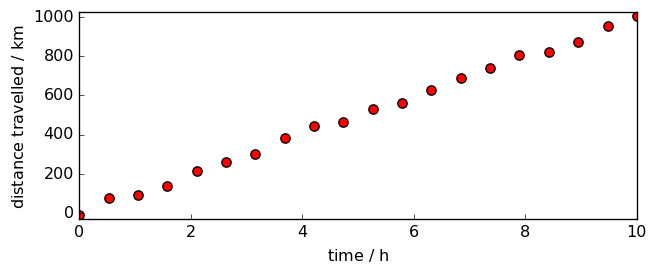

In [3]:
prefs = scp.preferences
prefs.figure.figsize = (7, 3)
d.plot_scatter(markersize=7, mfc="red", label="Original data")

We want to fit a line through these data-points of equation

$d = v.t + d_0$

By construction, we know already that the line should have a
gradient of roughly 100 km/h and cut the y-axis at, more or less, 0 km.

Using LSTSQ, the solution is found very easily:

speed : 99.919 kilometer hour^-1,  distance at time 0 : -1.375 kilometer


<Matplotlib Axes object>

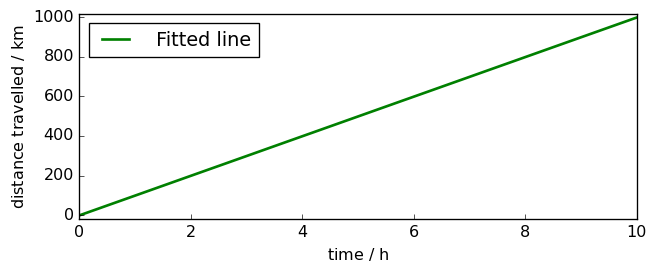

In [4]:
lst = scp.LSTSQ()
lst.fit(time, d)

v, d0 = lst.coef, lst.intercept
print(f"speed : {v:.3f},  distance at time 0 : {d0:.3f}")

dfit = lst.predict()
dfit.plot_pen(clear=False, color="g", lw=2, label=" Fitted line", legend="best")

<div class="alert alert-info">
<b>Note</b>

In the particular case where the variation is proportional to the x dataset
coordinate, the same result can be obtained directly using ``d`` as a single
parameter on LSTSQ (as ``t  `` is the ``x`` coordinate axis!)
</div>

In [5]:
lst = scp.LSTSQ()
lst.fit(d)
v, d0 = lst.coef, lst.intercept

and the final plot

<Matplotlib Axes object>

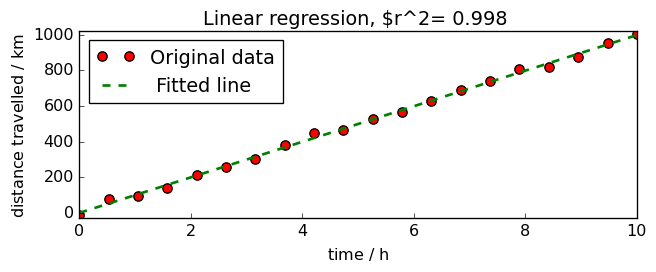

In [6]:
d.plot_scatter(
    markersize=7,
    mfc="red",
    mec="black",
    label="Original data",
    title=f"Linear regression, $r^2={lst.score(): .3f} ",
)
dfit = lst.predict()
dfit.plot_pen(clear=False, color="g", lw=2, label=" Fitted line", legend="best")

Let's try now with a quadratic increase of the speed:

<Matplotlib Axes object>

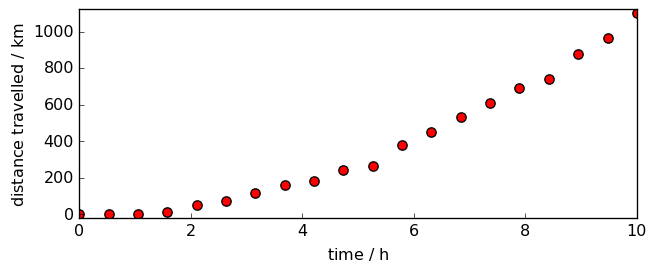

In [7]:
def func(t, a, var):
    d = a * (t / 3.0) ** 2 + (np.random.rand(len(t)) - 0.8) * var
    for i in range(t.size):
        if d[i].magnitude < 0:
            d[i] = 0.0 * d.units
    return d


time = scp.Coord.linspace(0, 10, 20, title="time", units="hour")
d2 = scp.NDDataset.fromfunction(
    func,
    a=100.0 * ur("km/hr^2"),
    var=60.0 * ur("km"),
    # extra arguments passed to the function v, var
    coordset=scp.CoordSet(t=time),
    name="mydataset",
    title="distance travelled",
)

d2.plot_scatter(markersize=7, mfc="red")

Now we must use the first syntax LSTQ(X, Y) as the variation is not proportional
to time, but to its square.

In [8]:
X = time**2
lst = scp.LSTSQ()
lst.fit(X, d2)

v, d0 = lst.coef, lst.intercept
print(f"acceleration : {v:.3f},  distance at time 0 : {d0:.3f}")

acceleration : 10.959 kilometer hour^-2,  distance at time 0 : -1.464 kilometer


<Matplotlib Axes object>

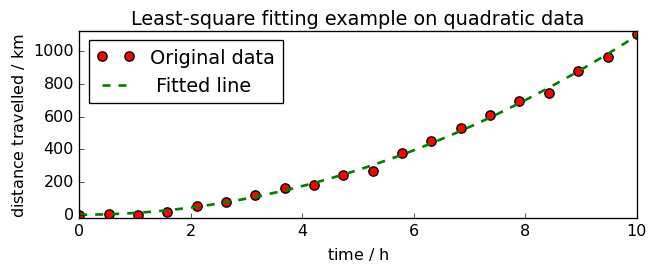

In [9]:
d2.plot_scatter(
    markersize=7,
    mfc="red",
    mec="black",
    label="Original data",
    title="Least-square fitting example on quadratic data",
)
dfit = lst.predict()

dfit.plot_pen(clear=False, color="g", lw=2, label=" Fitted line", legend="best")

## Least square with non-negativity constraint (NNLS)

When fitting data with LSTSQ, it happens that we get some negative values were
it should not, for instance having a negative distance at time 0.

In this case, we can use the NNLS method of fitting. It operates as `LSTSQ`
but keep the Y values always positive.

In [10]:
X = time**2
nls = scp.NNLS()
nls.fit(X, d2)

v, d0 = lst.coef, lst.intercept
print(f"acceleration : {v: .3f},  distance at time 0 : {d0: .3f}")

acceleration :  10.959 kilometer hour^-2,  distance at time 0 : -1.464 kilometer


<Matplotlib Axes object>

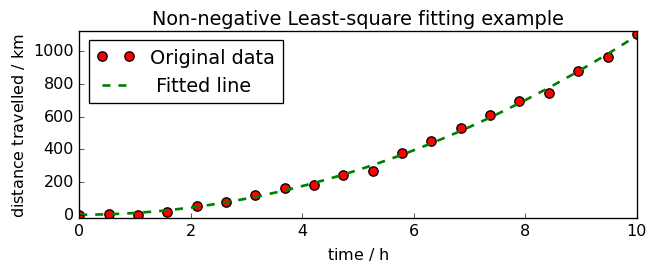

In [11]:
d2.plot_scatter(
    markersize=7,
    mfc="red",
    mec="black",
    label="Original data",
    title="Non-negative Least-square fitting example",
)
dfit = lst.predict()

dfit.plot_pen(clear=False, color="g", lw=2, label=" Fitted line", legend="best")

## NDDataset modelling using non-linear optimisation method

First we will load an IR dataset

In [12]:
nd = scp.read("irdata/nh4y-activation.spg")

As we want to start with a single 1D spectra, we select the last one (index -1)

In [13]:
nd = nd[-1].squeeze()
# nd[-1] returns a nddataset with shape (1,5549)
# this is why we squeeze it to get a pure 1D dataset with shape (5549,)

Now we slice it to keep only the OH vibration region:

<Matplotlib Axes object>

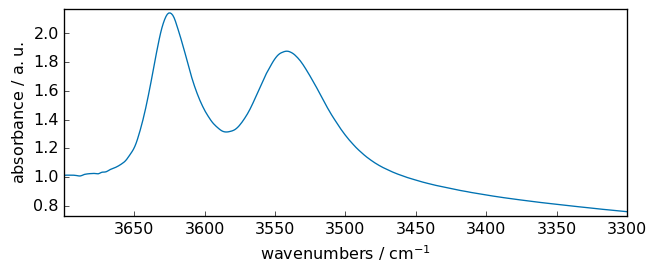

In [14]:
ndOH = nd[3700.0:3300.0]
ndOH.plot()

### Baseline correction

We can perform a linear baseline correction to start with this data (see the
:doc:`baseline tutorial </userguide/processing/baseline>`).
For removing a linear baseline, the fastest method is however to use the `abc` (
automatic baseline correction)

<Matplotlib Axes object>

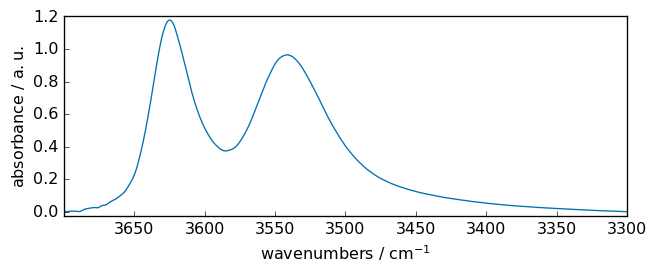

In [15]:
ndOHcorr = scp.basc(ndOH)
ndOHcorr.plot()

### Peak finding

Below we will need to start with some guess of the peak position and width.
For this we can use the `find_peaks()` method
(see :doc:`Peak finding tutorial </userguide/analysis/peak_finding>`)

In [16]:
peaks, _ = ndOHcorr.find_peaks()
peaks.x.values

Magnitude,[3693.693 3678.355 3624.857 3541.323]
Units,cm-1


<Matplotlib Axes object>

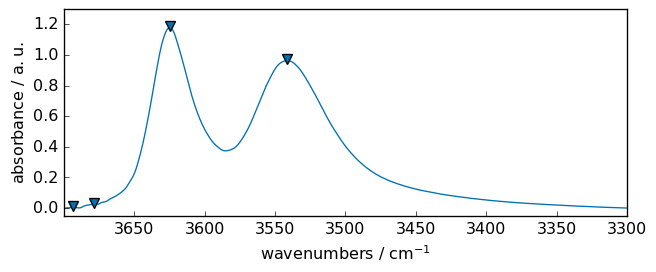

In [17]:
ax = ndOHcorr.plot_pen()  # output the spectrum on ax. ax will receive next plot too
pks = peaks + 0.01  # add a small offset on the y position of the markers
pks.plot_scatter(
    ax=ax,
    marker="v",
    color="black",
    clear=False,  # we need to keep the previous output on ax
    data_only=True,  # we don't need to redraw all things like labels, etc...
    ylim=(-0.05, 1.3),
)

The maximum of the two major peaks are thus exactly at 3624.61 and 3541.68 cm$^{-1}$

### Fitting script
Now we will define the fitting procedure as a script

In [18]:
script = """

#-----------------------------------------------------------
# syntax for parameters definition :
# name : value, low_bound,  high_bound
#  * for fixed parameters
#  $ for variable parameters
#  > for reference to a parameter in the COMMON block
#    (> is forbidden in the COMMON block)
# common block parameters should not have a _ in their names
#-----------------------------------------------------------
#
COMMON:
# common parameters ex.
# $ gwidth: 1.0, 0.0, none
$ gratio: 0.1, 0.0, 1.0
$ gasym: 0.1, 0, 1

MODEL: LINE_1
shape: asymmetricvoigtmodel
    * ampl:  1.0, 0.0, none
    $ pos:   3624.61, 3610.0, 3640.0
    > ratio: gratio
    > asym: gasym
    $ width: 200, 0, 1000

MODEL: LINE_2
shape: asymmetricvoigtmodel
    $ ampl:  0.2, 0.0, none
    $ pos:   3541.68, 3520.0, 3560.0
    > ratio: gratio
    > asym: gasym
    $ width: 200, 0, 1000

"""

#### Syntax for parameters definition

In such script, the char `#` at the beginning of a line denote that the whole line is
a comment. Comments are
obviously optional but may be useful to explain

Each individual model component is identified by the keyword `MODEL`

A `MODEL` have a name, *e.g.*, `MODEL: LINE_1` .

Then come for each model components its `shape` , *i.e.,* the shape of the line.

Come after the definition of the model parameters depending on the shape, e.g., for
a `gaussianmodel` we have three
parameters: `amplitude` (`ampl`), `width` and `position` (`pos`) of the line.

To define a given parameter, we have to write its `name` and a set of 3 values:
the expected `value` and 2 limits
for the allowed variations : `low_bound`,  `high_bound`:

```
name : value, low_bound,  high_bound
```
These parameters are preceded by a mark saying what kind of parameter it will behave
in the fit procedure:

* `$` is the default and denote a variable parameters
* `*` denotes fixed parameters
* `>` say that the given parameters is actually defined in a COMMON block

`COMMON`is the common block containing parameters to which a parameter in the MODEL
blocks can make reference using
the  `>` markers.  (`>` obviously is forbidden in the COMMON block)
common block parameters should not have a `_`(underscore) in their names

With this parameter script definition, you can thus make rather complex search for
modelling, as you can make
parameters dependents or fixed.

The line shape can be (up to now) in the following list of shape (for 1D models -
see below for 2D):

* PolynomialBaseline -> `polynomialbaseline`:

  Arbitrary-degree polynomial (degree limited to 10, however). As a linear
  baseline is automatically calculated
  during fitting, this polynom is always of
  greater or equal to order 2 (parabolic function at the minimum).

  $f(x) = ampl * \sum_{i=2}^{max} c_i*x^i$

  ```
  MODEL: baseline
  shape: polynomialbaseline
  # This polynomial starts at the order 2
  $ ampl: val, 0.0, None
  $ c_2: 1.0, None, None
  * c_3: 0.0, None, None
  * c_4: 0.0, None, None
  # etc
  ```


* Gaussian Model -> `gaussianmodel`:

  Normalized 1D gaussian function.

  $f(x) = \frac{ampl}{\sqrt{2 \pi \sigma^2}} \exp({\frac{-(x-pos)^2}{2 \sigma^2}})$

  where $\sigma = \frac{width}{2.3548}$

  ```
  MODEL: Linex
  shape: gaussianmodel
  $ ampl: val, 0.0, None
  $ width: val, 0.0, None
  $ pos: val, lob,  upb
  ```


* Lorentzian Model -> `lorentzianmodel`:

  A standard Lorentzian function (also known as the Cauchy distribution).

  $f(x) = \frac{ampl * \lambda}{\pi [(x-pos)^2+ \lambda^2]}$

  where $\lambda = \frac{width}{2}$

  ```
  MODEL: liney:
  shape: lorentzianmodel
  $ ampl:val, 0.0, None
  $ width: val, 0.0, None
  $ pos: val, lob, upb
  ```


* Voigt Model -> `voigtmodel`:

  A Voigt model constructed as the convolution of a `GaussianModel` and
  a `LorentzianModel` -- commonly used for spectral line fitting.

  ```
  MODEL: linez
  shape: voigtmodel
  $ ampl: val, 0.0, None
  $ width: val, 0.0, None
  $ pos: val, lob, upb
  $ ratio: val, 0.0, 1.0
  ```


* Asymmetric Voigt Model -> `asymmetricvoigtmodel`:

  An asymmetric Voigt model
  (A. L. Stancik and E. B. Brauns, Vibrational Spectroscopy, 2008, 47, 66-69)

  ```
  MODEL: linez
  shape: voigtmodel
  $ ampl: val, 0.0, None
  $ width: val, 0.0, None
  $ pos: val, lob, upb
  $ ratio: val, 0.0, 1.0
  $ asym: val, 0.0, 1.0
  ```

 **************************************************


 Result:


 **************************************************



 COMMON:
	$ gratio:     0.5474, 0.0, 1.0
	$ gasym:     0.8842, 0, 1

 MODEL: line_1
 shape: asymmetricvoigtmodel
	* ampl:     1.0000, 0.0, none
	> asym:gasym
	$ pos:  3622.7494, 3610.0, 3640.0
	> ratio:gratio
	$ width:    48.6369, 0, 1000

 MODEL: line_2
 shape: asymmetricvoigtmodel
	$ ampl:     0.9059, 0.0, none
	> asym:gasym
	$ pos:  3537.1347, 3520.0, 3560.0
	> ratio:gratio
	$ width:    77.5669, 0, 1000



<Matplotlib Axes object>

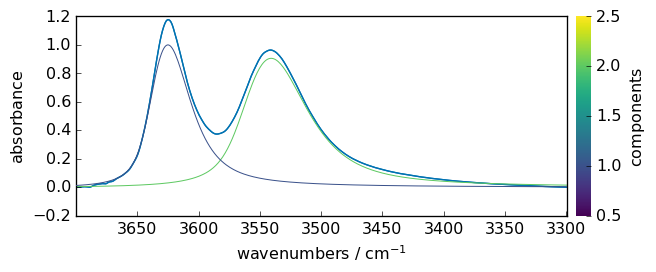

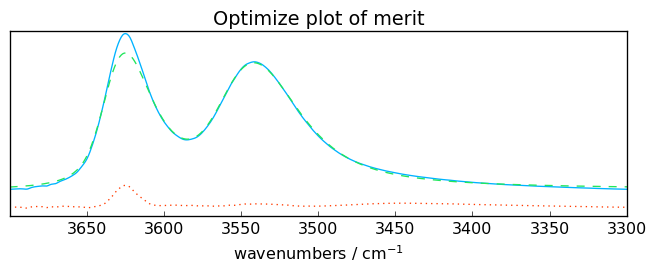

In [19]:
f1 = scp.Optimize(log_level="INFO")
f1.script = script
f1.max_iter = 2000
# f1.autobase = True
f1.fit(ndOHcorr)

# Show the result
ndOHcorr.plot()
ax = (f1.components[:]).plot(clear=False)
ax.autoscale(enable=True, axis="y")

# plotmerit
som = f1.inverse_transform()
f1.plotmerit(offset=0, kind="scatter")

<div class='alert alert-warning'>
<b>Todo</b>

Tutorial to be continued with other methods of optimization and fitting (2D...)
</div>